<a href="https://colab.research.google.com/github/Ahmed0236/Data-Science/blob/main/Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project : The Battle of Neighborhoods
### Applied Data Science Capstone by IBM/Coursera





## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Crimes in Boston](#crimes)
* [Rents in Boston](#rents)
* [Cluster of venues](#clusters)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a> 

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an restaurant in Boston, Massachusetts.

Since there are lots of restaurants in Massachusetts we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with low crime rate** and areas that have **reasonable rent**.

We will use K-means clustering to segment and cluster the venues in each neighborhoods. 

## Data <a name="data"></a>



To cater this problem we will need the following data sets
data set which are freely available.

*   [Crimes in Boston](https://www.kaggle.com/AnalyzeBoston/crimes-in-boston) from Kaggle which contains the data of all the crimes occured in different neighborhoods in boston in recent times.

*   [Boston Rental Data](https://http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_ZriPerSqft_AllHomes.csv') from Zillow which is real estate website containing most up to date rental data in Boston Neighborhoods.

*   [Boston Police Districts](https://bpdnews.com/districts) from Boston Police Department website. We need this because we need to encode District Abbrevations into Boston Neighborhoods 








## Crimes in Boston <a name="crimes"></a>

#### Import necessary packages

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

from zipfile import ZipFile
import requests
from bs4 import BeautifulSoup



print('Libraries imported.')

Libraries imported.


#### Read the Boston Crimes data set

In [ ]:
#download and upload data manually
data1 = pd.read_csv('crime.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Utility Funtion to extract data from the web in the correct format

In [ ]:
def DistrictData():

    url = 'https://bpdnews.com/districts'
    source = requests.get(url).text
    soup = BeautifulSoup(source,'lxml')

    links = soup.find_all('div', attrs={'class': 'sqs-block-content'})
    h2s = soup.find_all('h2')

    def getCodes(h2s):
        container = []
        i = 0
        for h2 in h2s:
            i = i + 1
            line = h2.find('strong').text
            if i == 1:
                pass
            elif i == 2:
                code = line.split(' ')
                container.append(code[1].replace('-',''))
                container.append(code[3].replace('-',''))
            else:
                code = line.split(' ')
                container.append(code[1].replace('-',''))
        return container

    def getNames(h2s):
            container = []
            i = 0 
            for h2 in h2s:
                i = i + 1
                x = h2.text.split('-')
                if i == 1:
                    pass
                elif i == 2:
                    item = x[2][2:]
                    names = item.split(' ')
                    container.append(names[0])
                    container.append(names[2])
                elif i == 7 or i == 9 or i == 11 or i == 12:
                    name = x[1][2:]
                    container.append(name)
                else:
                    name = x[1][1:]
                    container.append(name)
            
            return container

    Districts = getNames(h2s)
    Codes = getCodes(h2s)

    #data = pd.DataFrame({'Code' : Codes, 'Neighborhood' : Districts})
    return Districts, Codes
  
l2, l1 = DistrictData()
print(l1)
print(l2)

['A1', 'A15', 'A7', 'B2', 'B3', 'C6', 'C11', 'D4', 'D14', 'E5', 'E13', 'E18']
['Downtown', 'Charlestown', 'East Boston', 'Roxbury', 'Mattapan', 'South Boston', 'Dorchester', 'South End', 'Brighton', 'West Roxbury', 'Jamaica Plain', 'Hyde Park']


#### Replace the Distrct codes with names

In [ ]:
data1.replace(l1,l2,inplace=True)
data1.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0      I182080058          2403  Disorderly Conduct   
1      I182080053          3201       Property Lost   
2      I182080052          2647               Other   
3      I182080051           413  Aggravated Assault   
4      I182080050          3122            Aircraft   

              OFFENSE_DESCRIPTION     DISTRICT REPORTING_AREA SHOOTING  \
0            DISTURBING THE PEACE    Hyde Park            495      NaN   
1                 PROPERTY - LOST     Brighton            795      NaN   
2       THREATS TO DO BODILY HARM      Roxbury            329      NaN   
3  ASSAULT - AGGRAVATED - BATTERY     Downtown             92      NaN   
4              AIRCRAFT INCIDENTS  East Boston             36      NaN   

  OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART        STREET  \
0  10/3/2018 20:13  2018     10   Wednesday    20    Part Two  ARLINGTON ST   
1  8/30/2018 20:00  2018      8    Thursday    20  Part Three    ALLSTON ST   
2  10/3/2018 19:20  2018     10   Wednesday    19    Part Two      DEVON ST   
3  10/3/2018 20:00  2018     10   Wednesday    20    Part One  CAMBRIDGE ST   
4  10/3/2018 20:49  2018     10   Wednesday    20  Part Three   PRESCOTT ST   

         Lat       Long                     Location  
0  42.262608 -71.121186  (42.26260773, -71.12118637)  
1  42.352111 -71.135311  (42.35211146, -71.13531147)  
2  42.308126 -71.076930  (42.30812619, -71.07692974)  
3  42.359454 -71.059648  (42.35945371, -71.05964817)  
4  42.375258 -71.024663  (42.37525782, -71.02466343)

#### Find the total crimes in each neighborhood

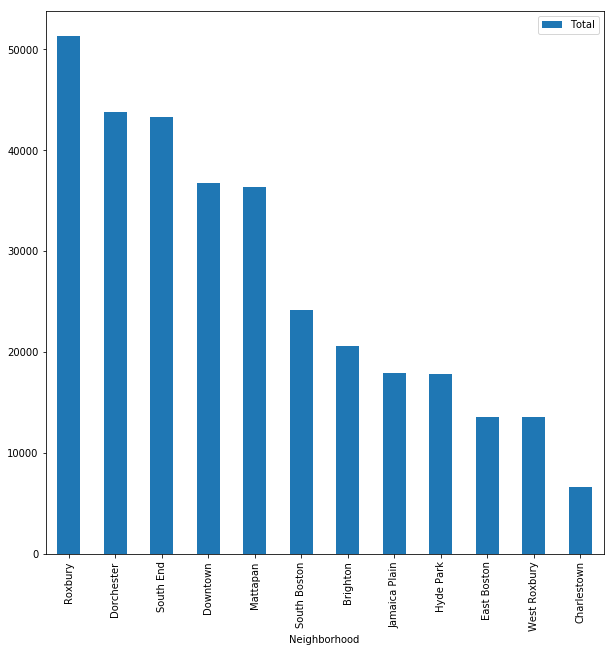

In [ ]:
crime_count = data1['DISTRICT'].value_counts()
a = crime_count.index
b = crime_count.values


crime_count = pd.DataFrame({'Neighborhood': a, 'Total' : b})
plot = crime_count.plot(kind = 'bar',x='Neighborhood',y='Total', figsize = (10,10))

fig = plot.get_figure()
fig.savefig("output.png")

#### Find the top 10 offenses in Boston

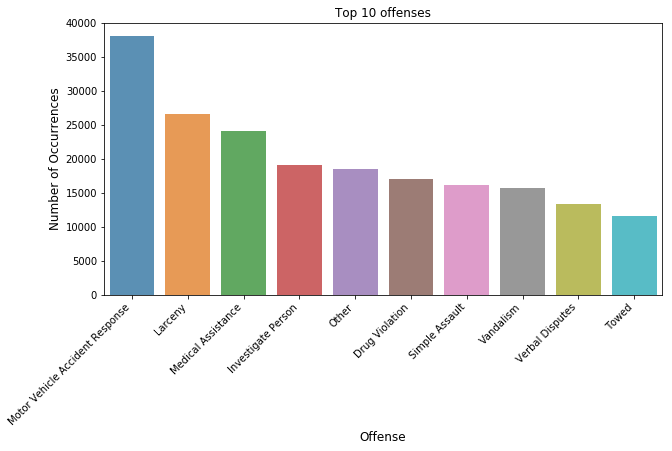

In [ ]:
top10offense = data1['OFFENSE_CODE_GROUP'].value_counts()[:10,]

plt.figure(figsize=(10,5))
sns.barplot(top10offense.index, top10offense.values, alpha=0.8)
plt.title('Top 10 offenses')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Offense', fontsize=12)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-large'  
)
plt.savefig('top10offense.png')
plt.show()

We can see that Larceny, otherwise known as theft, is very prolifent in Boston

#### Subset data for the year 2018 and offense of shoplifting 


In [ ]:
data2 = data1[data1['OFFENSE_CODE_GROUP'] == 'Larceny']
data2 = data2[data2['OFFENSE_DESCRIPTION']=='LARCENY SHOPLIFTING']
data2 = data2[data2['YEAR']==2018].reset_index(drop=True)
data2 = data2.iloc[0:500,:]
print(data2.shape)
data2.head()

(500, 17)


INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP  OFFENSE_DESCRIPTION  \
0      I182080029           613            Larceny  LARCENY SHOPLIFTING   
1      I182080003           613            Larceny  LARCENY SHOPLIFTING   
2      I182079973           613            Larceny  LARCENY SHOPLIFTING   
3      I182079942           613            Larceny  LARCENY SHOPLIFTING   
4      I182079899           613            Larceny  LARCENY SHOPLIFTING   

       DISTRICT REPORTING_AREA SHOOTING OCCURRED_ON_DATE  YEAR  MONTH  \
0     South End            146      NaN  10/3/2018 19:09  2018     10   
1  South Boston            214      NaN  10/3/2018 17:45  2018     10   
2      Downtown             94      NaN  10/3/2018 13:40  2018     10   
3      Downtown            103      NaN  10/3/2018 14:47  2018     10   
4      Mattapan            427      NaN  10/3/2018 13:38  2018     10   

  DAY_OF_WEEK  HOUR  UCR_PART                    STREET        Lat       Long  \
0   Wednesday    19  Part One            HUNTINGTON AVE  42.347972 -71.078496   
1   Wednesday    17  Part One                W BROADWAY  42.336112 -71.046654   
2   Wednesday    13  Part One  FANEUIL HALL MARKETPLACE  42.359980 -71.054741   
3   Wednesday    14  Part One             WASHINGTON ST  42.356801 -71.058930   
4   Wednesday    13  Part One             BLUE HILL AVE  42.274701 -71.093441   

                      Location  
0  (42.34797240, -71.07849582)  
1  (42.33611200, -71.04665434)  
2  (42.35997967, -71.05474135)  
3  (42.35680075, -71.05893025)  
4  (42.27470119, -71.09344053)

#### Extract the relevant Columns

In [ ]:
data3 = data2[['DISTRICT','STREET','Lat','Long']].dropna()
#data3.rename(columns={'OFFENSE_CODE_GROUP': 'OFFENSE'}, inplace = True)
print(data3.shape)
data3.head()

(489, 4)


DISTRICT                    STREET        Lat       Long
0     South End            HUNTINGTON AVE  42.347972 -71.078496
1  South Boston                W BROADWAY  42.336112 -71.046654
2      Downtown  FANEUIL HALL MARKETPLACE  42.359980 -71.054741
3      Downtown             WASHINGTON ST  42.356801 -71.058930
4      Mattapan             BLUE HILL AVE  42.274701 -71.093441

#### Create map and visualize 

In [ ]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [ ]:
boston_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [ ]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
boston_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(boston_map)


# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(data3.Lat, data3.Long, data3['STREET']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
boston_map.save('fig1.html')
boston_map

#### Analysis

We can observe that most of the offenses are centered aound the South End area therefore, this region would not be ideal for openning a new restaurant

## Rents in Boston  Neighborhoods<a name="rents"></a>


#### Download the Housing prices data set  and observe raw data

In [ ]:
housing_data = pd.read_csv('http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_ZriPerSqft_AllHomes.csv')
housing_data.head()

RegionID         RegionName         City State  \
0    274772   Northeast Dallas       Dallas    TX   
1    112345           Maryvale      Phoenix    AZ   
2    192689           Paradise    Las Vegas    NV   
3    270958    Upper West Side     New York    NY   
4    118208  South Los Angeles  Los Angeles    CA   

                            Metro          CountyName  SizeRank  2010-11  \
0     Dallas-Fort Worth-Arlington       Dallas County         1    0.844   
1         Phoenix-Mesa-Scottsdale     Maricopa County         2    0.672   
2    Las Vegas-Henderson-Paradise        Clark County         3    0.758   
3     New York-Newark-Jersey City     New York County         4    4.456   
4  Los Angeles-Long Beach-Anaheim  Los Angeles County         5    1.416   

   2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  \
0    0.850    0.858    0.862    0.862    0.858    0.856    0.858    0.860   
1    0.670    0.666    0.664    0.664    0.662    0.660    0.658    0.656   
2    0.756    0.754    0.752    0.750    0.748    0.746    0.744    0.744   
3    4.470    4.466    4.450    4.392    4.302    4.224    4.160    4.138   
4    1.412    1.410    1.414    1.414    1.410    1.406    1.400    1.404   

   2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  \
0    0.862    0.864    0.862    0.862    0.858    0.854    0.854    0.856   
1    0.656    0.654    0.652    0.650    0.646    0.642    0.638    0.636   
2    0.746    0.744    0.742    0.740    0.736    0.734    0.732    0.728   
3    4.098    4.092    4.046    4.014    3.986    3.990    4.020    4.044   
4    1.404    1.408    1.412    1.416    1.412    1.402    1.394    1.394   

   2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  \
0    0.860    0.864    0.872    0.882    0.892    0.900    0.904    0.904   
1    0.636    0.640    0.646    0.650    0.650    0.650    0.646    0.646   
2    0.728    0.726    0.728    0.730    0.730    0.728    0.726    0.724   
3    4.056    4.068    4.018    4.038    4.062    4.118    4.156    4.196   
4    1.396    1.400    1.394    1.386    1.370    1.360    1.356    1.356   

   2012-12  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  \
0    0.904    0.904    0.908    0.912    0.918    0.926    0.934    0.942   
1    0.646    0.648    0.646    0.648    0.650    0.652    0.654    0.656   
2    0.724    0.722    0.722    0.722    0.724    0.724    0.726    0.726   
3    4.210    4.150    4.074    4.058    4.098    4.150    4.218    4.242   
4    1.364    1.380    1.400    1.416    1.426    1.438    1.442    1.440   

   2013-08  2013-09  2013-10  2013-11  2013-12  2014-01  2014-02  2014-03  \
0    0.944    0.952    0.958    0.966    0.968    0.972    0.976    0.978   
1    0.658    0.660    0.658    0.658    0.660    0.662    0.662    0.660   
2    0.728    0.730    0.732    0.732    0.730    0.728    0.728    0.728   
3    4.208    4.164    4.170    4.234    4.326    4.404    4.476    4.522   
4    1.434    1.432    1.442    1.456    1.464    1.462    1.456    1.446   

   2014-04  2014-05  2014-06  2014-07  2014-08  2014-09  2014-10  2014-11  \
0    0.980    0.982    0.986    0.994    1.010    1.024    1.032    1.036   
1    0.660    0.662    0.666    0.672    0.676    0.678    0.680    0.682   
2    0.728    0.730    0.730    0.734    0.736    0.740    0.742    0.742   
3    4.542    4.536    4.528    4.532    4.556    4.604    4.688    4.782   
4    1.452    1.454    1.456    1.456    1.466    1.496    1.522    1.556   

   2014-12  2015-01  2015-02  2015-03  2015-04  2015-05  2015-06  2015-07  \
0    1.036    1.036    1.036    1.038    1.042    1.052    1.068    1.084   
1    0.688    0.692    0.696    0.698    0.702    0.704    0.710    0.718   
2    0.742    0.742    0.742    0.744    0.748    0.750    0.754    0.760   
3    4.836    4.880    4.912    4.938    4.958    4.974    4.994    5.020   
4    1.580    1.604    1.620    1.636    1.642    1.644    1.646

#### Make necessary changes in the dataset

In [ ]:
rents = housing_data.loc[(housing_data['State'] == 'MA') & (housing_data['City']=='Boston'),['RegionName','2019-06']].reset_index(drop=True)
rents.rename(columns={'RegionName':'Neighborhood','2019-06':'Median price per sqft'}, inplace = True)
temp = rents.iloc[1:]
temp.replace('North Dorchester','Dorchester',inplace = True)
temp1 = temp.append({'Neighborhood':'Seaport District','Median price per sqft':3.577},ignore_index=True)
temp2 = temp1.append({'Neighborhood':'Longwood Medical Area','Median price per sqft':2.534},ignore_index=True)
rents = temp2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


#### Utility Function for getting the coordinates of a neighborhood

In [ ]:
#get the coordinates
def getCoordinates(address):
  geolocator = Nominatim(user_agent="ny_explorer")
  location = geolocator.geocode(address)
  latitude = location.latitude
  longitude = location.longitude
  return latitude,longitude

#### Get the coordinates and append in the dataframe

In [ ]:
neighborhoods = rents['Neighborhood']

Latitudes = []
Longitudes = []

for n in neighborhoods:
  address = n + ', MA, USA'
  lat,lon = getCoordinates(address)
  #print(n + ' ' +str(lat)+','+str(lon))
  Latitudes.append(lat)
  Longitudes.append(lon)

rents['Lat'] = Latitudes
rents['Lon'] = Longitudes

rents.replace(['Seaport District','Longwood Medical Area'],['South Boston Waterfront','Longwood'],inplace= True)
rents

Neighborhood  Median price per sqft        Lat        Lon
0                   Roxbury                  1.914  42.324843 -71.095016
1             Jamaica Plain                  2.360  42.309820 -71.120330
2               East Boston                  2.442  42.375097 -71.039217
3                  Brighton                  2.896  42.350097 -71.156442
4                  Mattapan                  1.896  42.272321 -71.086995
5              South Boston                  2.994  42.333431 -71.049495
6                 Hyde Park                  1.984  42.255654 -71.124496
7              West Roxbury                  1.940  42.279265 -71.149497
8                 South End                  3.670  42.095928 -72.582866
9                Roslindale                  1.992  42.291209 -71.124497
10               Dorchester                  2.286  42.297320 -71.074495
11                  Allston                  3.018  42.355434 -71.132127
12                 Back Bay                  4.088  42.350707 -71.079730
13                   Fenway                  4.216  42.343451 -71.097716
14              Charlestown                  2.838  42.377875 -71.061996
15                  Kenmore                  4.084  39.692611 -75.867163
16             Mission Hill                  2.524  42.332926 -71.103214
17                North End                  3.734  42.365097 -71.054495
18              Beacon Hill                  4.260  42.359820 -71.066162
19                Chinatown                  4.002  42.352217 -71.062607
20                 West End                  3.290  42.363919 -71.063899
21                 Downtown                  3.592  42.263069 -71.802002
22              Bay Village                  3.984  42.350011 -71.066948
23  South Boston Waterfront                  3.577  42.348765 -71.043988
24                 Longwood                  2.534  42.336168 -71.099527

#### Download the Bostone GeoJson file for Constructing the Map

In [ ]:
!wget --quiet http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson -O Boston.json
print('json file downloaded')

json file downloaded


#### Construct the Choropleth map of boston with respect to  rents 

In [ ]:
boston_geo = r'Boston.json'
with open('Boston.json') as json_data:
    boston_data = json.load(json_data)

del(boston_data['features'][-1])

boston_map = folium.Map(location=[42.3602534, -71.0582912], zoom_start=12)

boston_map.choropleth(
    geo_data=boston_data,
    data=rents,
    columns=['Neighborhood', 'Median price per sqft'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Housing Prices per sqft',
    reset=True
)
boston_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Analysis of  Rents

As shown in the map, we observe that the regions in the southeren reghion have very high rent. Thus, these regions should not be chosen if there are budget constraints.

## Clustering of neighborhoods<a name="clusters"></a>

#### Define credentials for **Foursquare**

In [ ]:
CLIENT_ID = 'MWJ54SMBOGYZOKQPTV3ZDM3VUPROJXUDD5MK5BDWKKYSDTSS' # your Foursquare ID
CLIENT_SECRET = '5C1ZPNIZY2IQEL5CMN1AS22DED4EY0ILTZOTX40C4ACTE20Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MWJ54SMBOGYZOKQPTV3ZDM3VUPROJXUDD5MK5BDWKKYSDTSS
CLIENT_SECRET:5C1ZPNIZY2IQEL5CMN1AS22DED4EY0ILTZOTX40C4ACTE20Y


### Get Nearby Venues 

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
       
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
boston_venues = getNearbyVenues(names=rents['Neighborhood'],
                                latitudes=rents['Lat'],
                                longitudes=rents['Lon'])

### Observe and analyze the data

#### Size of data

In [ ]:
print(boston_venues.shape)
boston_venues.head()

(1726, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Roxbury              42.324843              -71.095016   
1      Roxbury              42.324843              -71.095016   
2      Roxbury              42.324843              -71.095016   
3      Roxbury              42.324843              -71.095016   
4      Roxbury              42.324843              -71.095016   

                           Venue  Venue Latitude  Venue Longitude  \
0           Crossfit On The Hill       42.328008       -71.098176   
1            Diablo Glass School       42.328085       -71.098262   
2                       Milkweed       42.332168       -71.099424   
3      Boston Building Resources       42.328696       -71.097894   
4  Lilly's Gourmet Pasta Express       42.332445       -71.100046   

            Venue Category  
0                      Gym  
1              Art Gallery  
2  New American Restaurant  
3   Furniture / Home Store  
4       Italian Restaurant

#### How many venues were returned for each neighborhood

In [ ]:
boston_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                    
Allston                                     87                      87     87   
Back Bay                                   100                     100    100   
Bay Village                                100                     100    100   
Beacon Hill                                100                     100    100   
Brighton                                    79                      79     79   
Charlestown                                 69                      69     69   
Chinatown                                  100                     100    100   
Dorchester                                  16                      16     16   
Downtown                                   100                     100    100   
East Boston                                 43                      43     43   
Fenway                                     100                     100    100   
Hyde Park                                   33                      33     33   
Jamaica Plain                               58                      58     58   
Kenmore                                      2                       2      2   
Longwood                                   100                     100    100   
Mattapan                                    22                      22     22   
Mission Hill                                70                      70     70   
North End                                  100                     100    100   
Roslindale                                  41                      41     41   
Roxbury                                     38                      38     38   
South Boston                                73                      73     73   
South Boston Waterfront                    100                     100    100   
South End                                   43                      43     43   
West End                                   100                     100    100   
West Roxbury                                52                      52     52   

                         Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                              
Allston                              87               87              87  
Back Bay                            100              100             100  
Bay Village                         100              100             100  
Beacon Hill                         100              100             100  
Brighton                             79               79              79  
Charlestown                          69               69              69  
Chinatown                           100              100             100  
Dorchester                           16               16              16  
Downtown                            100              100             100  
East Boston                          43               43              43  
Fenway                              100              100             100  
Hyde Park                            33               33              33  
Jamaica Plain                        58               58              58  
Kenmore                               2                2               2  
Longwood                            100              100             100  
Mattapan                             22               22              22  
Mission Hill                         70               70              70  
North End                           100              100             100  
Roslindale                           41               41              41  
Roxbury                              38               38              38  
South Boston                         73               73              73  
South Boston Waterfront             100              100             100  
South End                            

#### How many different categories were returned 

In [ ]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))

There are 242 uniques categories.


### Prepare data for clusering

#### One hot encodding for venues

In [ ]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

Yoga Studio  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0            0    0                  0                  0                   0   
1            0    0                  0                  0                   0   
2            0    0                  0                  0                   0   
3            0    0                  0                  0                   0   
4            0    0                  0                  0                   0   

   American Restaurant  Antique Shop  Art Gallery  Art Museum  \
0                    0             0            0           0   
1                    0             0            1           0   
2                    0             0            0           0   
3                    0             0            0           0   
4                    0             0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Beach  Bed & Breakfast  Beer Bar  \
0                 0                 0      0                0         0   
1                 0                 0      0                0         0   
2                 0                 0      0                0         0   
3                 0                 0      0                0         0   
4                 0                 0      0                0         0   

   Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  \
0            0           0                   0              0   
1            0           0                   0              0   
2            0           0                   0              0   
3            0           0                   0              0   
4            0           0                   0              0   

   Bike Rental / Bike Share  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0                         0       0           0              0          0   
1                         0       0           0              0          0   
2                         0       0           0              0          0   
3                         0       0           0              0          0   
4                         0       0           0              0          0   

   Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  \
0         0              0           0                     0               0   
1         0              0           0                     0               0   
2         0              0           0                     0               0   
3         0              0           0                     0               0   
4         0              0           0                     0               0   

   Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  \
0        0                0         0             0              0   
1        0                0         0             0              0   
2        0                0         0             0              0   
3        0                0         0             0              0   
4        0                0         0             0

#### Observe the data

In [ ]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped

Neighborhood  Yoga Studio       ATM  Accessories Store  \
0                   Allston     0.011494  0.000000           0.000000   
1                  Back Bay     0.010000  0.000000           0.020000   
2               Bay Village     0.010000  0.000000           0.000000   
3               Beacon Hill     0.010000  0.000000           0.000000   
4                  Brighton     0.000000  0.000000           0.000000   
5               Charlestown     0.000000  0.000000           0.000000   
6                 Chinatown     0.000000  0.000000           0.000000   
7                Dorchester     0.000000  0.000000           0.000000   
8                  Downtown     0.000000  0.000000           0.000000   
9               East Boston     0.000000  0.000000           0.000000   
10                   Fenway     0.010000  0.000000           0.000000   
11                Hyde Park     0.000000  0.000000           0.000000   
12            Jamaica Plain     0.034483  0.000000           0.034483   
13                  Kenmore     0.000000  0.000000           0.000000   
14                 Longwood     0.000000  0.000000           0.000000   
15                 Mattapan     0.000000  0.000000           0.000000   
16             Mission Hill     0.000000  0.000000           0.000000   
17                North End     0.010000  0.000000           0.000000   
18               Roslindale     0.048780  0.000000           0.000000   
19                  Roxbury     0.000000  0.000000           0.000000   
20             South Boston     0.000000  0.013699           0.000000   
21  South Boston Waterfront     0.000000  0.000000           0.000000   
22                South End     0.000000  0.000000           0.000000   
23                 West End     0.020000  0.000000           0.000000   
24             West Roxbury     0.000000  0.000000           0.000000   

    Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0            0.011494            0.000000             0.011494          0.00   
1            0.000000            0.000000             0.040000          0.00   
2            0.000000            0.000000             0.020000          0.00   
3            0.000000            0.000000             0.040000          0.00   
4            0.000000            0.000000             0.012658          0.00   
5            0.000000            0.000000             0.014493          0.00   
6            0.000000            0.000000             0.000000          0.00   
7            0.000000            0.000000             0.000000          0.00   
8            0.000000            0.000000             0.040000          0.01   
9            0.000000            0.000000             0.000000          0.00   
10           0.000000            0.000000             0.050000          0.00   
11           0.000000            0.000000             0.060606          0.00   
12           0.000000            0.000000             0.034483          0.00   
13           0.000000            0.000000             0.000000          0.00   
14           0.000000            0.010000             0.040000          0.00   
15           0.000000            0.000000             0.045455          0.00   
16           0.000000            0.014286             0.014286          0.00   
17           0.000000            0.000000             0.010000          0.00   
18           0.000000            0.000000             0.073171          0.00   
19           0.000000            0.026316             0.000000          0.00   
20           0.000000            0.000000             0.013699          0.00   
21           0.000000            0.000000             0.010000          0.00   
22           0.000000            0.000000             0.046512          0.00   
23           0.000000            0.000000             0.010000          0.00   
24           0.000000            0.000000             0.038462          0.00   

    Art Gallery  Art Museum  Arts &

#### Get the top 5 categories for each neighborhood

In [ ]:
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                venue  freq
0         Pizza Place  0.06
1   Korean Restaurant  0.06
2  Chinese Restaurant  0.05
3              Bakery  0.05
4                 Bar  0.03


----Back Bay----
                 venue  freq
0   Italian Restaurant  0.04
1                Hotel  0.04
2          Coffee Shop  0.04
3       Ice Cream Shop  0.04
4  American Restaurant  0.04


----Bay Village----
                venue  freq
0         Coffee Shop  0.06
1                 Spa  0.06
2             Theater  0.05
3  Italian Restaurant  0.05
4  Chinese Restaurant  0.04


----Beacon Hill----
                 venue  freq
0   Italian Restaurant  0.06
1  American Restaurant  0.04
2                Hotel  0.04
3          Pizza Place  0.04
4          Coffee Shop  0.04


----Brighton----
           venue  freq
0    Pizza Place  0.08
1    Coffee Shop  0.05
2            Pub  0.05
3  Grocery Store  0.04
4     Donut Shop  0.04


----Charlestown----
            venue  freq
0            Park  0.06
1   Grocer

#### Get the top 10 Most common Venue

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                   Allston           Pizza Place     Korean Restaurant   
1                  Back Bay    Italian Restaurant   American Restaurant   
2               Bay Village           Coffee Shop                   Spa   
3               Beacon Hill    Italian Restaurant                 Hotel   
4                  Brighton           Pizza Place           Coffee Shop   
5               Charlestown                  Park                  Café   
6                 Chinatown      Asian Restaurant           Coffee Shop   
7                Dorchester           Pizza Place              Pharmacy   
8                  Downtown                  Café        Sandwich Place   
9               East Boston    Mexican Restaurant                  Park   
10                   Fenway   American Restaurant                  Café   
11                Hyde Park           Pizza Place         Grocery Store   
12            Jamaica Plain                  Park                Bakery   
13                  Kenmore                  Farm          Liquor Store   
14                 Longwood                  Café           Pizza Place   
15                 Mattapan            Donut Shop         Women's Store   
16             Mission Hill            Donut Shop                  Café   
17                North End    Italian Restaurant                  Park   
18               Roslindale           Pizza Place   American Restaurant   
19                  Roxbury            Donut Shop           Pizza Place   
20             South Boston           Pizza Place                   Bar   
21  South Boston Waterfront                 Hotel    Seafood Restaurant   
22                South End           Pizza Place        Shipping Store   
23                 West End    Italian Restaurant                Bakery   
24             West Roxbury           Pizza Place              Pharmacy   

   3rd Most Common Venue      4th Most Common Venue   5th Most Common Venue  \
0     Chinese Restaurant                     Bakery                     Bar   
1     Seafood Restaurant                      Hotel             Coffee Shop   
2     Italian Restaurant                    Theater          Sandwich Place   
3            Pizza Place        American Restaurant             Coffee Shop   
4                    Pub              Grocery Store              Donut Shop   
5              Gastropub              Grocery Store              Donut Shop   
6         Sandwich Place         Chinese Restaurant      Italian Restaurant   
7    Fried Chicken Joint          Mobile Phone Shop                Platform   
8                    Bar                 Donut Shop     American Restaurant   
9     Italian Restaurant  Latin American Restaurant             Pizza Place   
10       Thai Restaurant     Furniture / Home Store              Restaurant   
11                  Park               Home Service                Pharmacy   
12           Pizza Place                Coffee Shop  Thrift / Vintage Store   
13         Women's Store                       Food             Fish Market   
14           Coffee Shop        American Restaurant                    Park   
15        Hardware Store                 Playground             Pizza Place   
16        Sandwich Place                Pizza Place             Coffee Shop   
17           Pizza Place                     Bakery      Seafood Restaurant   
18         Grocery Store                Yoga Studio                   Plaza   
19          Skating Rink          Convenience Store      Italian Restaurant   
20            Donut Shop             Sandwich Place             Coffee Shop   
21    Italian Restaurant                 Steakhouse             Coffee Shop   
22            Donut Shop                     Casino              Sports Bar   
23           Pizza Place                       Park      Seafood Restaurant   
24     Convenience Store               Liquor Store                    Bank   

   6th Mo

#### Create Clusters of venues

In [ ]:
# set number of clusters
kclusters = 7

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

#check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 0, 0, 1, 6, 5, 5], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = rents

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged.head() # check the last columns!

Neighborhood  Median price per sqft        Lat        Lon  Cluster Labels  \
0        Roxbury                  1.914  42.324843 -71.095016               5   
1  Jamaica Plain                  2.360  42.309820 -71.120330               1   
2    East Boston                  2.442  42.375097 -71.039217               5   
3       Brighton                  2.896  42.350097 -71.156442               0   
4       Mattapan                  1.896  42.272321 -71.086995               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0            Donut Shop           Pizza Place          Skating Rink   
1                  Park                Bakery           Pizza Place   
2    Mexican Restaurant                  Park    Italian Restaurant   
3           Pizza Place           Coffee Shop                   Pub   
4            Donut Shop         Women's Store        Hardware Store   

       4th Most Common Venue   5th Most Common Venue 6th Most Common Venue  \
0          Convenience Store      Italian Restaurant          Burger Joint   
1                Coffee Shop  Thrift / Vintage Store        Ice Cream Shop   
2  Latin American Restaurant             Pizza Place                  Café   
3              Grocery Store              Donut Shop     Convenience Store   
4                 Playground             Pizza Place              Pharmacy   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Sandwich Place                  Park          Liquor Store   
1  New American Restaurant                   Pub             Bookstore   
2             Liquor Store        Sandwich Place    Seafood Restaurant   
3       Chinese Restaurant                  Café                Bakery   
4        Mobile Phone Shop         Metro Station          Liquor Store   

  10th Most Common Venue  
0      Mobile Phone Shop  
1            Yoga Studio  
2          Burrito Place  
3        Thai Restaurant  
4         Ice Cream Shop

#### Observe Boston Rents with Clusters

In [ ]:
boston_map = folium.Map(location=[42.3602534, -71.0582912], zoom_start=12)

boston_map.choropleth(
    geo_data=boston_data,
    data=rents,
    columns=['Neighborhood', 'Median price per sqft'],
    key_on='feature.properties.Name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Housing Prices per sqft',
    highlight = True,
    reset=True
)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, price, venue, cluster in zip(boston_merged['Lat'], boston_merged['Lon'], boston_merged['Neighborhood'], boston_merged['Median price per sqft'], boston_merged['1st Most Common Venue'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(neigh)+'\n'+ 
                         'Cluster:'+ 
                         str(cluster)+'\n'+
                         'Avg Price:'+ 
                         str(format(price,'.2f'))+'\n'+ 
                         'Venue:'+
                         str(venue)+'\n', 
                         parse_html = True,
                         max_width = '200%')
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(boston_map)
       
boston_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Let's view the clusters

In [ ]:
def top3(cluster):
  temp = cluster.iloc[:,1:4].apply(pd.value_counts)
  temp = temp.sum(axis = 1).sort_values(ascending = False)
  venue = temp.index[0:3]
  count = temp.values[0:3]
  count = [int(i) for i in count]
 
  for i in range(3):
    label = str(count[i])+ " "+  venue[i]
    print(label)
  return venue,count


#### Cluster 1

In [ ]:
cluster1 = boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster1)

6 Pizza Place
2 Park
2 Grocery Store


#### Cluster 2

In [ ]:
cluster2 = boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster2)

5 Italian Restaurant
3 Pizza Place
2 Seafood Restaurant


#### Cluster 3

In [ ]:
cluster3 = boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster3)

1 Women's Store
1 Liquor Store
1 Farm


#### Cluster 4

In [ ]:
cluster4 = boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster4)

1 Women's Store
1 Hardware Store
1 Donut Shop


#### Cluster 5

In [ ]:
cluster5 = boston_merged.loc[boston_merged['Cluster Labels'] == 4, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster5)

1 Pizza Place
1 Park
1 Italian Restaurant


####  Cluster 6

In [ ]:
cluster5 = boston_merged.loc[boston_merged['Cluster Labels'] == 5, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster5)

4 Café
3 Pizza Place
3 Donut Shop


#### Cluster 7

In [ ]:
cluster6 = boston_merged.loc[boston_merged['Cluster Labels'] == 6, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]].reset_index(drop=True)
a,b = top3(cluster6)

1 Pizza Place
1 Pharmacy
1 Fried Chicken Joint


## Conclusion<a name="conclusion"></a>

As per our analysis we can see the southeren region of Boston have the highest number of cluster centers. This indicates greater chances of prosperous business. However, there is also a tradeoff that comes in terms of high rent. In addition, there are greater occurences of crimes in that region. In a nutshell, there is plenty of information available for law enforcement agencies, real-estate agents and ctiy councils to improve standards in the city